In [1]:
import geopandas as gpd
import geo
import fiona
import contextily as ctx
import geopandas as gpd
import pandas as pd
from shapely import geometry
import matplotlib.pyplot as plt
from wilcoxon import sheets
from shapely.ops import nearest_points
%matplotlib inline

In [1]:
from geo.locations.mrt.station import Station, Stations
from geo.locations.mrt.mrt_line import MRTLine
from geo.locations.network import Network
from geo.color.color import Color
from geo.geom.line import Line
from geo.geom.geo_pt import GeoPt
from geo.geom.pt import Pt

In [14]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
lines = gpd.read_file("../Geospatial/Sheets/mrt-line.kml")
lines.loc[5:8,"geometry"] = lines.loc[5:8, "geometry"].boundary
lines.drop(columns=["Description"], inplace=True)
lines.Name = lines.Name.str.extract("([^L]+)")
lines_dict = lines.set_index("Name").to_dict("index")
lines_dict["CE"] = {}
lines_dict["CE"]["geometry"] = geometry.LineString(list(GeoPt(x[1], x[0]) for x in lines_dict["CC"]["geometry"].coords[346:][::-1]))

In [3]:
network = Network(year=2020)

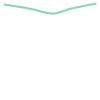

In [17]:
network.stations["Bishan"].platforms[0].lower_connection

In [ ]:
for station in network.stations:
    for platform in station.platforms:
        prefix = platform.platform_code.prefix
        if "platforms" not in lines_dict[prefix]:
            lines_dict[prefix]["platforms"] = [platform]
        else:
            lines_dict[prefix]["platforms"].append(platform)

In [111]:
[GeoPt(point[1], point[0]) for point in lines_dict["CC"]["geometry"].coords]

[(1.2989032, 103.8453894),
 (1.2987638, 103.8459366),
 (1.2985278, 103.846827),
 (1.2983669, 103.8473635),
 (1.2981738, 103.847975),
 (1.2980666, 103.8483613),
 (1.2979271, 103.8488012),
 (1.2977555, 103.849241),
 (1.2976161, 103.8495307),
 (1.2974015, 103.8499384),
 (1.2970476, 103.8504427),
 (1.2966507, 103.8509255),
 (1.2962431, 103.8514619),
 (1.2958248, 103.8519983),
 (1.2954279, 103.8525133),
 (1.2948595, 103.8532644),
 (1.2934651, 103.855099),
 (1.2926713, 103.8564079),
 (1.2924032, 103.8569551),
 (1.2921136, 103.8576846),
 (1.2916738, 103.8585322),
 (1.2915344, 103.8591116),
 (1.29147, 103.8597875),
 (1.29147, 103.8601308),
 (1.2915773, 103.860517),
 (1.2916845, 103.8607745),
 (1.2918132, 103.860914),
 (1.2919849, 103.8611715),
 (1.2922959, 103.8612251),
 (1.2927786, 103.8612037),
 (1.2940765, 103.8610106),
 (1.2952349, 103.8608496),
 (1.2962002, 103.8607316),
 (1.2972728, 103.8606887),
 (1.2976268, 103.8608711),
 (1.2981524, 103.8610964),
 (1.2985814, 103.8615256),
 (1.2989139

In [84]:
line = Line.from_linestring(lines_dict["CE"]["geometry"])
platforms = sorted(lines_dict["CE"]["platforms"])

In [7]:
def get_segments(line_name):
    line = Line.from_linestring(lines_dict[line_name]["geometry"])
    line = Line(list(GeoPt(x[1], x[0]) for x in line.coords[346:][::-1]))
    platforms = sorted(lines_dict[line_name]["platforms"])

    # Get the closest projections onto the line
    projections = [GeoPt(1,2)]
    for platform in platforms:
        projections.append(line.get_nearest(platform)[0])

    segments = []
    curr_start = 0
    for i in range(len(projections)-1):
        lower_proj = projections[i]
        upper_proj = projections[i+1]
        curr_segment = [lower_proj]

        for j in range(curr_start, len(line.coords)-1):
            p1 = line.coords[j]
            p2 = line.coords[j+1]
            min_lat = min(p1[1], p2[1])
            min_lon = min(p1[0], p2[0])
            max_lat = max(p1[1], p2[1])
            max_lon = max(p1[0], p2[0])
            curr_segment.append(GeoPt(p1[1], p1[0]))
            if min_lat <= upper_proj.lat <= max_lat and min_lon <= upper_proj.lon <= max_lon:
                curr_start = j+1
                break

        curr_segment.append(upper_proj)

        if i != 0:
            segments.append(Line(curr_segment))
    
    return segments

In [9]:
get_connections("DT")

NameError: name 'lines_dict' is not defined

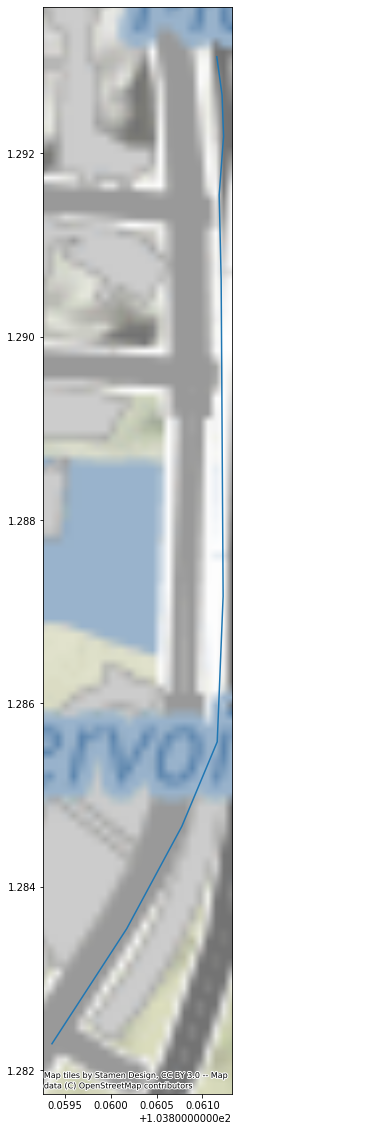

In [88]:
ax = gpd.GeoDataFrame(geometry=segments[:1]).plot(figsize=(20,20))
ctx.add_basemap(ax=ax, zoom=14, crs="EPSG:4326")